## CREDIT DEFAULT PREDICTION WITH THE PROSPER LOAN DATASET. 

#### 1. IMPORT ALL PACKAGES

In [34]:
# Import necessary packages
import pandas as pd
import numpy as np

# Import data cleaning and model accuracy tools
#from sklearn.model_selection import train_test_split # Splits data
from sklearn.preprocessing import LabelEncoder # Convert categor. to numeric
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import accuracy_score # Test accuracy of model predoctions
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import random

# Import models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
# To suppress ugly warnings
import warnings

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns  

#### 1.1 LOAD DATA

In [35]:
# Import data
df = pd.read_csv("C:/Users/david/Desktop/FINISHED/ProsperLoanData.csv", encoding = "ISO-8859-1") 

#### 2. EXPLORE DATA

#### 2.1 DROP USELESS COLUMNS
Some features are not appropriate predictors such as 'LoanKey' or 'LoanListing' others were dropped for simplicity.

In [36]:
df = df.drop(columns=['LoanKey','BorrowerState','Occupation','Investors','ScorexChangeAtTimeOfListing','Recommendations','InvestmentFromFriendsCount','TotalInquiries','InvestmentFromFriendsAmount','InvestmentFromFriendsCount','LoanOriginationQuarter','GroupKey','LoanOriginationDate', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'ListingKey', 'ListingNumber', 'ListingCreationDate', 'ClosedDate', 'ListingCategory (numeric)', 'CurrentlyInGroup', 'GroupKey', 'DateCreditPulled', 'OpenCreditLines', 'CurrentCreditLines', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months',  'RevolvingCreditBalance', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'LoanFirstDefaultedCycleNumber', 'LoanMonthsSinceOrigination', 'LoanNumber', 'MemberKey', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'PercentFunded', 'LP_NonPrincipalRecoverypayments', 'LP_CollectionFees', 'LoanCurrentDaysDelinquent', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn','FirstRecordedCreditLine'])

In [37]:
print("PROSPER LOAN DATASET OVERVIEW:\n ")
print(len(df.columns), " Columns")
print(len(df), " Instances\n")
categorical_variables, numeric_variables = [],[]
for col in list(df.columns):
    if df[col].dtype.kind == "O":
        categorical_variables.append(col)
    else:
        numeric_variables.append(col)

print("NUMERIC VARIABLES:\n")
for var in sorted(numeric_variables):
    print(var[0],"     ",var)
print("\nCATEGORICAL VARIABLES:\n")
for var in sorted(categorical_variables):
        print(var[0],"     ",var)

PROSPER LOAN DATASET OVERVIEW:
 
29  Columns
113937  Instances

NUMERIC VARIABLES:

A       AmountDelinquent
A       AvailableBankcardCredit
B       BankcardUtilization
B       BorrowerAPR
C       CreditScoreRangeLower
C       CreditScoreRangeUpper
C       CurrentDelinquencies
D       DebtToIncomeRatio
D       DelinquenciesLast7Years
E       EmploymentStatusDuration
I       IncomeVerifiable
I       IsBorrowerHomeowner
L       LoanOriginalAmount
M       MonthlyLoanPayment
P       ProsperRating (numeric)
P       ProsperScore
P       PublicRecordsLast10Years
P       PublicRecordsLast12Months
S       StatedMonthlyIncome
T       Term
T       TotalCreditLinespast7years
T       TotalTrades
T       TradesNeverDelinquent (percentage)
T       TradesOpenedLast6Months

CATEGORICAL VARIABLES:

C       CreditGrade
E       EmploymentStatus
I       IncomeRange
L       LoanStatus
P       ProsperRating (Alpha)


#### 2.2 DEFINE TARGET VARIABLE
A new target variable must be created, 'Defaulted'.....
'Defaulted' replaces 'LoanStatus'.....
Defaulted = 1, Completed = 0.....

In [38]:
def completed_or_defaulted_chargedoff(x):# creates a new target column
    if x == "Completed":
        return 0
    elif x == "Defaulted" or x == "Chargedoff":
        return 1

###### Overview LoanStatus

In [39]:
print("VARIABLE STATES LoanStatus\n")
for state in set(df['LoanStatus']):
    print(state)

VARIABLE STATES LoanStatus

Completed
Current
Past Due (16-30 days)
Past Due (31-60 days)
Past Due (1-15 days)
Past Due (61-90 days)
FinalPaymentInProgress
Past Due (91-120 days)
Past Due (>120 days)
Cancelled
Chargedoff
Defaulted


##### Create Defaulted Variable

In [40]:
df['Defaulted'] = df['LoanStatus'].map(lambda x: completed_or_defaulted_chargedoff(x))

In [41]:
df = df[df['Defaulted'].notnull()]# delete useless rows

In [42]:
print("VARIABLE STATES Completed-Defaulted-Chargedoff\n")
for state in set(df['Defaulted']):
    print(state)

VARIABLE STATES Completed-Defaulted-Chargedoff

0.0
1.0


#####  Delete redundant column 'LoanStatus'

In [43]:
df = df.drop(columns=['LoanStatus'])# drop column LoanStatus

### 3. DEFINE PREDICTOR VARIABLES

#### 3.1 NUMERIC VARIABLES:

In [44]:
print("NUMERIC VARIABLES:                                Contains Nulls\n")
for var in sorted(numeric_variables):
    print(var[0],"     ",var," "*(40-len(var)),df[var].isnull().values.any())

NUMERIC VARIABLES:                                Contains Nulls

A       AmountDelinquent                          True
A       AvailableBankcardCredit                   True
B       BankcardUtilization                       True
B       BorrowerAPR                               True
C       CreditScoreRangeLower                     True
C       CreditScoreRangeUpper                     True
C       CurrentDelinquencies                      True
D       DebtToIncomeRatio                         True
D       DelinquenciesLast7Years                   True
E       EmploymentStatusDuration                  True
I       IncomeVerifiable                          False
I       IsBorrowerHomeowner                       False
L       LoanOriginalAmount                        False
M       MonthlyLoanPayment                        False
P       ProsperRating (numeric)                   True
P       ProsperScore                              True
P       PublicRecordsLast10Years                  

##### Replace Nulls with the variable average

In [45]:
print("NUMERIC VARIABLES:                                Contains Nulls\n")
for var in sorted(numeric_variables):
    df[var].fillna(df[var].mean(), inplace=True)
    print(var[0],"     ",var," "*(40-len(var)),df[var].isnull().values.any())

NUMERIC VARIABLES:                                Contains Nulls

A       AmountDelinquent                          False
A       AvailableBankcardCredit                   False
B       BankcardUtilization                       False
B       BorrowerAPR                               False
C       CreditScoreRangeLower                     False
C       CreditScoreRangeUpper                     False
C       CurrentDelinquencies                      False
D       DebtToIncomeRatio                         False
D       DelinquenciesLast7Years                   False
E       EmploymentStatusDuration                  False
I       IncomeVerifiable                          False
I       IsBorrowerHomeowner                       False
L       LoanOriginalAmount                        False
M       MonthlyLoanPayment                        False
P       ProsperRating (numeric)                   False
P       ProsperScore                              False
P       PublicRecordsLast10Years      

#### 3.2 CATEGORICAL VARIABLES

In [46]:
def get_unique(col):
    print("\nCOLUMN:",col)
    print("COUNT UNIQUE VALUES:",len(df[col].unique()))
    print("UNIQUE VALUES:",df[col].unique())

In [47]:
for col in df.columns:
    if df[col].dtype == object:
        get_unique(col)


COLUMN: CreditGrade
COUNT UNIQUE VALUES: 9
UNIQUE VALUES: ['C' 'HR' nan 'AA' 'D' 'B' 'E' 'A' 'NC']

COLUMN: ProsperRating (Alpha)
COUNT UNIQUE VALUES: 8
UNIQUE VALUES: [nan 'HR' 'D' 'E' 'A' 'AA' 'B' 'C']

COLUMN: EmploymentStatus
COUNT UNIQUE VALUES: 9
UNIQUE VALUES: ['Self-employed' 'Not available' 'Full-time' 'Other' 'Employed' nan
 'Not employed' 'Part-time' 'Retired']

COLUMN: IncomeRange
COUNT UNIQUE VALUES: 8
UNIQUE VALUES: ['$25,000-49,999' 'Not displayed' '$1-24,999' '$50,000-74,999'
 '$75,000-99,999' '$100,000+' 'Not employed' '$0']


#### Transform Ordinal Categories suchs as CreditGrades to Numeric

In [48]:
the_grades = {'C': 4, 'HR': 8, 'AA': 1, 'D': 6,\
              'B':3, 'E':7, 'A': 2, 'NC': 5}
                # Dictionary for mapping values

def numeric_grades(value): # function maps the dictionary the_months
    if value not in the_grades:
        return None
    else:
        return the_grades[value] 

df["CreditGrade"] = df["CreditGrade"].apply(numeric_grades) # convert column

In [49]:
the_grades = {'C': 4, 'HR': 7, 'AA': 1, 'D': 5,\
              'B':3, 'E':6, 'A': 2}
                # Dictionary for mapping values

def numeric_grades(value): # function maps the dictionary the_months
    if value not in the_grades:
        return None
    else:
        return the_grades[value] 

df["ProsperRating (Alpha)"] = df["ProsperRating (Alpha)"].apply(numeric_grades) # convert column

In [50]:
print("NEW NUMERIC VARIABLES:                                Contains Nulls\n")
df["CreditGrade"].fillna(df[var].mean(), inplace=True)
print("CreditGrade"," "*(55-len("CreditGrade")),df[var].isnull().values.any())
df["ProsperRating (Alpha)"].fillna(df[var].mean(), inplace=True)
print("ProsperRating (Alpha)"," "*(55-len("ProsperRating (Alpha)")),df[var].isnull().values.any())

NEW NUMERIC VARIABLES:                                Contains Nulls

CreditGrade                                              False
ProsperRating (Alpha)                                    False


#### ONE-HOT ENCODING Remaining Categoricals

#### There are 2 remaining Categoricals

In [51]:
for col in df.columns:
    if df[col].dtype == object:
        get_unique(col)


COLUMN: EmploymentStatus
COUNT UNIQUE VALUES: 9
UNIQUE VALUES: ['Self-employed' 'Not available' 'Full-time' 'Other' 'Employed' nan
 'Not employed' 'Part-time' 'Retired']

COLUMN: IncomeRange
COUNT UNIQUE VALUES: 8
UNIQUE VALUES: ['$25,000-49,999' 'Not displayed' '$1-24,999' '$50,000-74,999'
 '$75,000-99,999' '$100,000+' 'Not employed' '$0']


In [52]:
df = pd.get_dummies(df) # One hot encoding remaining variables

#### 3.3 EXPLORE FINAL MODEL FEATURES

In [53]:
print("Total number of features =",len(df.columns))
print("Features:\n")
for var in sorted(df.columns):
    print(var[0],"     ",var)

Total number of features = 43
Features:

A       AmountDelinquent
A       AvailableBankcardCredit
B       BankcardUtilization
B       BorrowerAPR
C       CreditGrade
C       CreditScoreRangeLower
C       CreditScoreRangeUpper
C       CurrentDelinquencies
D       DebtToIncomeRatio
D       Defaulted
D       DelinquenciesLast7Years
E       EmploymentStatusDuration
E       EmploymentStatus_Employed
E       EmploymentStatus_Full-time
E       EmploymentStatus_Not available
E       EmploymentStatus_Not employed
E       EmploymentStatus_Other
E       EmploymentStatus_Part-time
E       EmploymentStatus_Retired
E       EmploymentStatus_Self-employed
I       IncomeRange_$0
I       IncomeRange_$1-24,999
I       IncomeRange_$100,000+
I       IncomeRange_$25,000-49,999
I       IncomeRange_$50,000-74,999
I       IncomeRange_$75,000-99,999
I       IncomeRange_Not displayed
I       IncomeRange_Not employed
I       IncomeVerifiable
I       IsBorrowerHomeowner
L       LoanOriginalAmount
M       MonthlyLo

### 4. MACHINE LEARNING

#### 4.1 TRAIN-TEST SPLIT

In [54]:
# Split into train/test set
test = df.sample(frac=0.2, replace=False, random_state=1)# 20% of data, without replacement, random seed
train = df.drop(test.index)

train_X = train.drop(columns=['Defaulted'])
train_y = train['Defaulted']
test_X = test.drop(columns=['Defaulted'])
test_y = test['Defaulted']

In [55]:
import warnings# Note i need to convert columns to get rid of these warnings 
warnings.filterwarnings('ignore')
scaler = StandardScaler()
scaler.fit(train_X) # fit scaler with training
train_X[train_X.columns] = scaler.transform(train_X[train_X.columns]) # transform training
test_X[test_X.columns] = scaler.transform(test_X[test_X.columns])# transform test
# Note i need to convert columns to get rid of these warnings 

#### 4.2 LOGISTIC REGRESSION

#### Stats Model Analysis of Logistic Regression

In [60]:
warnings.filterwarnings('ignore')
logit_model=sm.Logit(train_y,train_X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.625789
         Iterations: 35
                                           Results: Logit
Model:                          Logit                        Pseudo R-squared:             -0.013    
Dependent Variable:             Defaulted                    AIC:                          55233.2689
Date:                           2019-04-15 16:16             BIC:                          55581.0075
No. Observations:               44067                        Log-Likelihood:               -27577.   
Df Model:                       39                           LL-Null:                      -27230.   
Df Residuals:                   44027                        LLR p-value:                  1.0000    
Converged:                      0.0000                       Scale:                        1.0000    
No. Iterations:                 35.0000                                                              
------------------------------------------------------------

#### Sklearn Logistic Regression


LOGISTIC REGRESSION MODEL: 
Accuracy = 72.53 
ROC Accuracy = 61.02

Precision = 0.61 
Recall = 0.31 
F1-score = 0.41


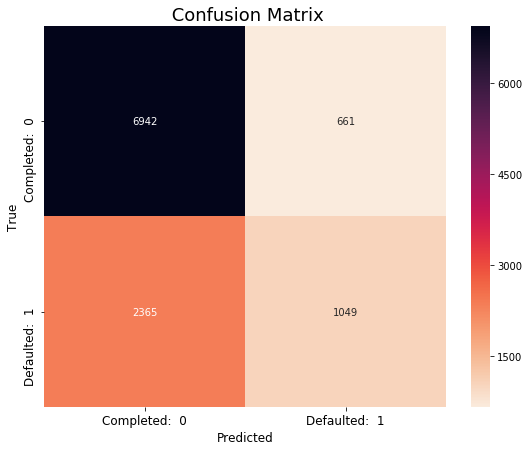

In [61]:
model_LOGREG = LogisticRegression(solver='liblinear') 
model_LOGREG.fit(train_X,train_y)
pred_LOGREG = model_LOGREG.predict(test_X)
acc, roc = round(accuracy_score(test_y, pred_LOGREG)*100,2), round(roc_auc_score(test_y, pred_LOGREG)*100,2)
precision, recall, f1score, support = metrics.precision_recall_fscore_support(test_y, pred_LOGREG)
precision, recall, f1score = round(precision[1],2), round(recall[1],2), round(f1score[1],2)
#models.append(("Logistic Regression",acc,roc,precision, recall, f1score))
print("\nLOGISTIC REGRESSION MODEL:","\nAccuracy =",acc,"\nROC Accuracy =",roc)
print("\nPrecision =",precision,"\nRecall =",recall,"\nF1-score =",f1score)
cm = metrics.confusion_matrix(test_y, pred_LOGREG)
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm,annot=True, ax=ax, fmt='g',cmap=cmap); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted',size=12);ax.set_ylabel('True',size=12); 
ax.set_title(' Confusion Matrix',size=18); 
ax.xaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12); ax.yaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12);

#### Model Weights

In [64]:
columns = list(df.columns) 
coefficients = list(model_LOGREG.coef_[0])
weights = [abs(x) for x in coefficients]
data = sorted(zip(weights,columns,coefficients),reverse=True)
print("Predictors ordered by Log Reg importance:\n")
for x in data:
    print(x[1]," "*(40-len(x[1])),round(x[2],2))

Predictors ordered by Log Reg importance:

BorrowerAPR                               0.53
ProsperRating (Alpha)                     -0.48
MonthlyLoanPayment                        0.43
ProsperRating (numeric)                   -0.39
Term                                      0.25
CurrentDelinquencies                      0.21
IsBorrowerHomeowner                       0.15
StatedMonthlyIncome                       -0.14
TradesOpenedLast6Months                   0.14
CreditScoreRangeUpper                     -0.14
CreditScoreRangeLower                     -0.14
EmploymentStatus_Retired                  0.1
IncomeRange_Not displayed                 0.09
EmploymentStatus_Not employed             0.09
IncomeRange_$1-24,999                     -0.08
ProsperScore                              0.08
CreditGrade                               0.08
LoanOriginalAmount                        -0.07
BankcardUtilization                       -0.07
Defaulted                                 0.07
IncomeRang

#### 4.2.1 LOGISTIC REGRESSION with Recursive Feature Elimination with Cross Validation
Recursive Feature Elimination is used to identify the best features, this provides a minor model accuracy improvement.

Optimal number of features : 27


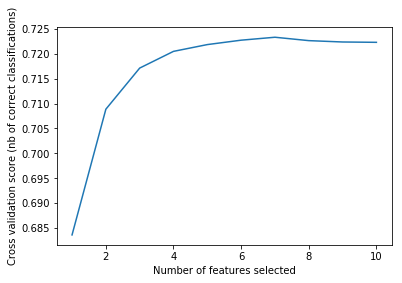

In [69]:
model_LOGREG = LogisticRegression(solver='liblinear') 

rfecv_LOGREG = RFECV(estimator=model_LOGREG, step=5, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv_LOGREG.fit(train_X, train_y)
print("Optimal number of features : %d" % rfecv_LOGREG.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_LOGREG.grid_scores_) + 1), rfecv_LOGREG.grid_scores_)
plt.show()


LOGISTIC REGRESSION RFE MODEL: 
Accuracy = 72.54 
ROC Accuracy = 61.07

Precision = 0.61 
Recall = 0.31 
F1-score = 0.41


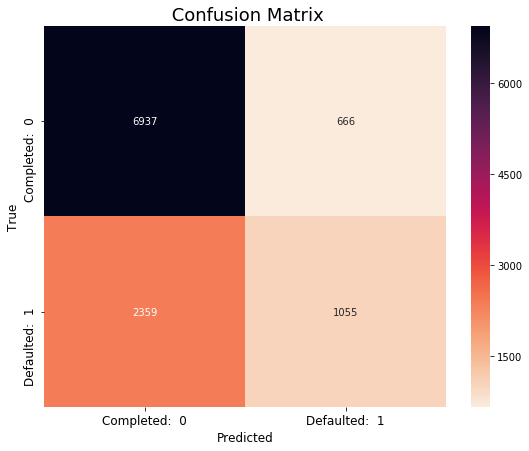

In [71]:
pred_LOGREG = rfecv_LOGREG.predict(test_X)
acc, roc = round(accuracy_score(test_y, pred_LOGREG)*100,2), round(roc_auc_score(test_y, pred_LOGREG)*100,2)
precision, recall, f1score, support = metrics.precision_recall_fscore_support(test_y, pred_LOGREG)
precision, recall, f1score = round(precision[1],2), round(recall[1],2), round(f1score[1],2)
#models.append(("Logistic Regression",acc,roc,precision, recall, f1score))
print("\nLOGISTIC REGRESSION RFE MODEL:","\nAccuracy =",acc,"\nROC Accuracy =",roc)
print("\nPrecision =",precision,"\nRecall =",recall,"\nF1-score =",f1score)
cm = metrics.confusion_matrix(test_y, pred_LOGREG)
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm,annot=True, ax=ax, fmt='g',cmap=cmap); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted',size=12);ax.set_ylabel('True',size=12); 
ax.set_title(' Confusion Matrix',size=18); 
ax.xaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12); ax.yaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12);

#### 4.3 RANDOM FOREST CLASSIFIER


RANDOM FOREST CLASSIFIER MODEL: 
Accuracy = 72.83 
ROC Accuracy = 62.11

Precision = 0.61 
Recall = 0.34 
F1-score = 0.44


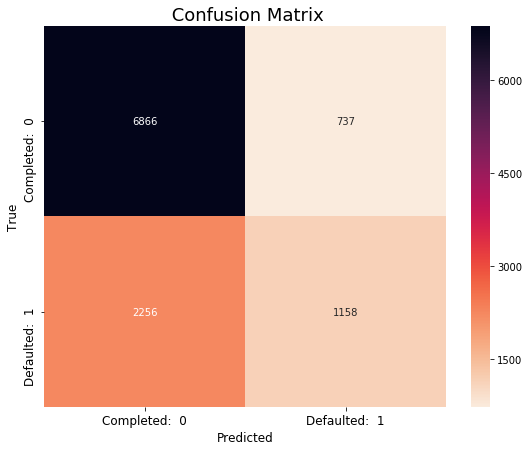

In [84]:
model_RFC = RandomForestClassifier(n_estimators=100) 
model_RFC.fit(train_X,train_y)
pred_RFC = model_RFC.predict(test_X)
acc, roc = round(accuracy_score(test_y, pred_RFC)*100,2), round(roc_auc_score(test_y, pred_RFC)*100,2)
precision, recall, f1score, support = metrics.precision_recall_fscore_support(test_y, pred_RFC)
precision, recall, f1score = round(precision[1],2), round(recall[1],2), round(f1score[1],2)
#models.append(("Logistic Regression",acc,roc,precision, recall, f1score))
print("\nRANDOM FOREST CLASSIFIER MODEL:","\nAccuracy =",acc,"\nROC Accuracy =",roc)
print("\nPrecision =",precision,"\nRecall =",recall,"\nF1-score =",f1score)
cm = metrics.confusion_matrix(test_y, pred_RFC)
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm,annot=True, ax=ax, fmt='g',cmap=cmap); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted',size=12);ax.set_ylabel('True',size=12); 
ax.set_title(' Confusion Matrix',size=18); 
ax.xaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12); ax.yaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12);

In [85]:
importances = [round(round(x,2)*100) for x in model_RFC.feature_importances_]
feat_vars = list(train_X.columns)
feature_importances = sorted(list(zip(importances,feat_vars)),reverse=True)
print("Random Forest Classifier Predictor Importances/Weights\n")
for x in feature_importances:
    print(x[1]," "*(40-len(x[1])),x[0])

Random Forest Classifier Predictor Importances/Weights

BorrowerAPR                               10.0
MonthlyLoanPayment                        8.0
StatedMonthlyIncome                       7.0
TotalCreditLinespast7years                6.0
EmploymentStatusDuration                  6.0
DebtToIncomeRatio                         6.0
AvailableBankcardCredit                   6.0
TotalTrades                               5.0
LoanOriginalAmount                        5.0
BankcardUtilization                       5.0
TradesNeverDelinquent (percentage)        4.0
CreditScoreRangeUpper                     4.0
CreditScoreRangeLower                     4.0
DelinquenciesLast7Years                   3.0
TradesOpenedLast6Months                   2.0
PublicRecordsLast10Years                  2.0
ProsperScore                              2.0
ProsperRating (numeric)                   2.0
CurrentDelinquencies                      2.0
CreditGrade                               2.0
AmountDelinquent       

#### 4.3.1 RANDOM FOREST CLASSIFIER with RFE & CV

Optimal number of features : 37


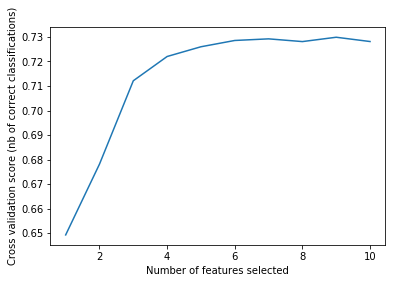

In [86]:
model_RFC = RandomForestClassifier(n_estimators=100) 

rfecv_RFC = RFECV(estimator=model_RFC, step=5, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv_RFC.fit(train_X, train_y)

print("Optimal number of features : %d" % rfecv_RFC.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_RFC.grid_scores_) + 1), rfecv_RFC.grid_scores_)
plt.show()


RANDOM FOREST CLASSIFIER MODEL: 
Accuracy = 72.62 
ROC Accuracy = 61.77

Precision = 0.61 
Recall = 0.33 
F1-score = 0.43


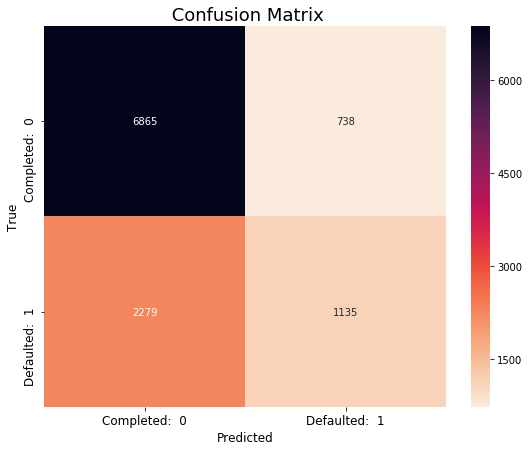

In [87]:
pred_RFC = rfecv_RFC.predict(test_X)
acc, roc = round(accuracy_score(test_y, pred_RFC)*100,2), round(roc_auc_score(test_y, pred_RFC)*100,2)
precision, recall, f1score, support = metrics.precision_recall_fscore_support(test_y, pred_RFC)
precision, recall, f1score = round(precision[1],2), round(recall[1],2), round(f1score[1],2)
#models.append(("Logistic Regression",acc,roc,precision, recall, f1score))
print("\nRANDOM FOREST CLASSIFIER MODEL:","\nAccuracy =",acc,"\nROC Accuracy =",roc)
print("\nPrecision =",precision,"\nRecall =",recall,"\nF1-score =",f1score)
cm = metrics.confusion_matrix(test_y, pred_RFC)
cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm,annot=True, ax=ax, fmt='g',cmap=cmap); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted',size=12);ax.set_ylabel('True',size=12); 
ax.set_title(' Confusion Matrix',size=18); 
ax.xaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12); ax.yaxis.set_ticklabels(['Completed:  0', 'Defaulted:  1'],size=12);

#### Below we see the feature rankings. The bottom 5 features were dropped to make 37 predictors

In [106]:
ranks = [round(round(x,2)*100) for x in rfecv_RFC.ranking_]
feat_vars = list(train_X.columns)
feature_ranks = sorted(list(zip(ranks,feat_vars)))
features_kept = feature_ranks[:rfecv_RFC.n_features_]
features_dropped = feature_ranks[rfecv_RFC.n_features_:]
print(rfecv_RFC.n_features_,"features kept:\n")
for x in features_kept:
    print(x[1])
print("\n",len(feat_vars)-rfecv_RFC.n_features_,"features dropped:\n")
for x in features_dropped:
    print(x[1])

37 features kept:

AmountDelinquent
AvailableBankcardCredit
BankcardUtilization
BorrowerAPR
CreditGrade
CreditScoreRangeLower
CreditScoreRangeUpper
CurrentDelinquencies
DebtToIncomeRatio
DelinquenciesLast7Years
EmploymentStatusDuration
EmploymentStatus_Employed
EmploymentStatus_Full-time
EmploymentStatus_Not available
EmploymentStatus_Other
EmploymentStatus_Retired
EmploymentStatus_Self-employed
IncomeRange_$1-24,999
IncomeRange_$100,000+
IncomeRange_$25,000-49,999
IncomeRange_$50,000-74,999
IncomeRange_$75,000-99,999
IncomeVerifiable
IsBorrowerHomeowner
LoanOriginalAmount
MonthlyLoanPayment
ProsperRating (Alpha)
ProsperRating (numeric)
ProsperScore
PublicRecordsLast10Years
PublicRecordsLast12Months
StatedMonthlyIncome
Term
TotalCreditLinespast7years
TotalTrades
TradesNeverDelinquent (percentage)
TradesOpenedLast6Months

 5 features dropped:

EmploymentStatus_Not employed
EmploymentStatus_Part-time
IncomeRange_$0
IncomeRange_Not displayed
IncomeRange_Not employed
